In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [101]:
#Essentials
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql
import matplotlib.pyplot as plt

#sklearn "magic"
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline

#Oversampling
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN


#Not sure about these ones yet
from sklearn.datasets import make_classification
from xgboost import XGBClassifier

#Different scores
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, f1_score, fbeta_score, roc_curve

#Nice to have
from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix
import seaborn as sns
plt.style.use('fivethirtyeight')
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display 
from ipywidgets import interactive, FloatSlider
from collections import Counter
#interactive(lambda threshold: make_confusion_matrix(lm, threshold), threshold=(0.0,1.0,0.02))

%matplotlib inline

In [3]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [4]:
# Postgres info to connect

connection_args = {
    'host': '18.222.192.127', 
    'user': 'ubuntu',    # username
    'dbname': 'student_grades',   # DB that we are connecting to
    'port': 5432         # port we opened on AWS
}

# We will talk about this magic Python trick!
connection = pg.connect(**connection_args)

In [5]:
### Let's combine the two SQL tables into one

append_query = """SELECT * 
                    FROM maths_grades

                    UNION ALL

                    SELECT * 
                    FROM portuguese_grades
                    """

grades = pd_sql.read_sql(append_query, connection)

In [6]:
grades.head()

,sex,age,address,famsize,Pstatus,Medu,Fedu,guardian,traveltime,studytime,...,freetime,goout,Dalc,Walc,health,absences,G3,discipline,final_grade_label,final_grade_segment
0,F,18,U,GT3,A,4,4,mother,2,2,...,3,4,1,1,3,6,6,maths,Fail,Fail
1,F,17,U,GT3,T,1,1,father,1,2,...,3,3,1,1,3,4,6,maths,Fail,Fail
2,F,15,U,LE3,T,1,1,mother,1,2,...,3,2,2,3,3,10,10,maths,Pass,Sufficient
3,F,15,U,GT3,T,4,2,mother,1,3,...,2,2,1,1,5,2,15,maths,Pass,Good
4,F,16,U,GT3,T,3,3,father,1,2,...,3,2,1,2,5,4,10,maths,Pass,Sufficient


### Let's dummify some variables

In [7]:
grades.columns

Index(['sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup',
       'famsup', 'paid', 'activities', 'higher', 'internet', 'romantic',
       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
       'G3', 'discipline', 'final_grade_label', 'final_grade_segment'],
      dtype='object')

In [8]:
#dummify sex (M=0, F=1)
grades['sex'].replace({'M': 0, 'F': 1}, inplace=True, axis=0)

#dummify address (U(urban)=0, R(rural)=1)
grades['address'].replace({'U': 0, 'R': 1}, inplace=True, axis=0)

#dummify famsize (LE3(less than/equal to 3)=0, GT3(greater than 3)=1)
grades['famsize'].replace({'LE3': 0, 'GT3': 1}, inplace=True, axis=0)

#dummify Pstatus(parent status) (T(together)=0, A(apart)=1)
grades['Pstatus'].replace({'T': 0, 'A': 1}, inplace=True, axis=0)

#dummify guardian (other=0, mother=1, father=2)
grades['guardian'].replace({'other': 0, 'mother': 1, 'father': 2}, inplace=True, axis=0)

#dummify discipline (maths=0, portuguese=1)
grades['discipline'].replace({'maths': 0, 'portuguese': 1}, inplace=True, axis=0)

#drop G3 column (obviously!)
grades.drop(columns='G3', inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4480: UserWarning: the "axis" argument is deprecated and will be removed inv0.13; this argument has no effect
  warnings.warn('the "axis" argument is deprecated '


### Feature and target analysis

In [9]:
print(grades['final_grade_label'].value_counts(), '\n')
print('% of Pass:', str(round(814 / 1044, 2)))
print('% of Fail:', str(round(230 / 1044, 2)), '\n')
print('Pass to Fail ratio in the dataset:', str(int((814 / 1044)*100))+':'+str(int((230 / 1044)*100)))
print('Percentage of Majority grade (Pass)', str(round((814 / 1044) *100, 0)))

Pass    814
Fail    230
Name: final_grade_label, dtype: int64 

% of Pass: 0.78
% of Fail: 0.22 

Pass to Fail ratio in the dataset: 77:22
Percentage of Majority grade (Pass) 78.0


> **This is not good!** I should look into oversampling or undersampling further down the line

In [10]:
feat, grade_label = grades.iloc[:, :-2], grades.iloc[:, -2]

In [11]:
#print(feat.head())
#print(grade_label.head())

In [12]:
#grades.corr()

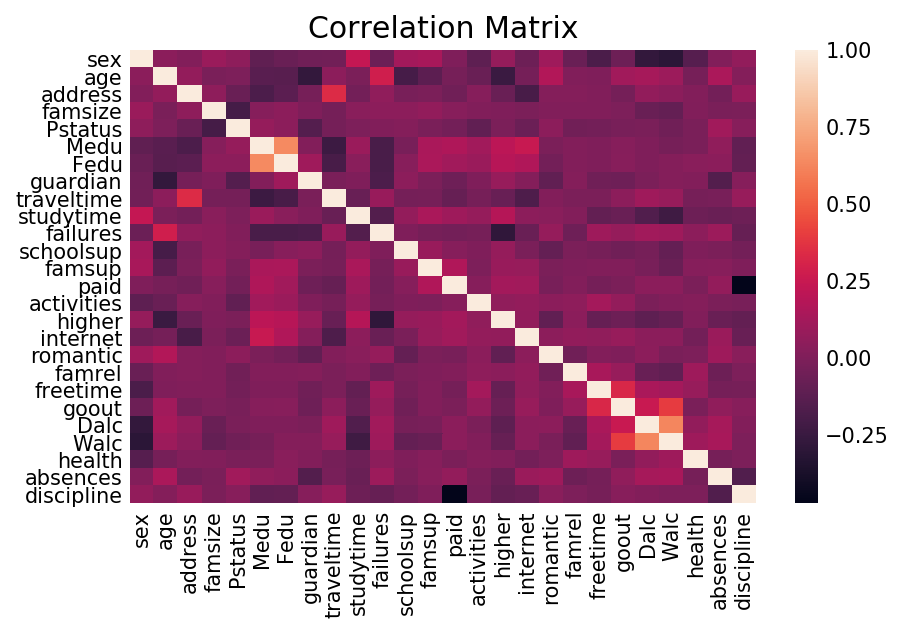

In [13]:
plt.figure(dpi=150)
plt.title('Correlation Matrix')
corr = grades.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

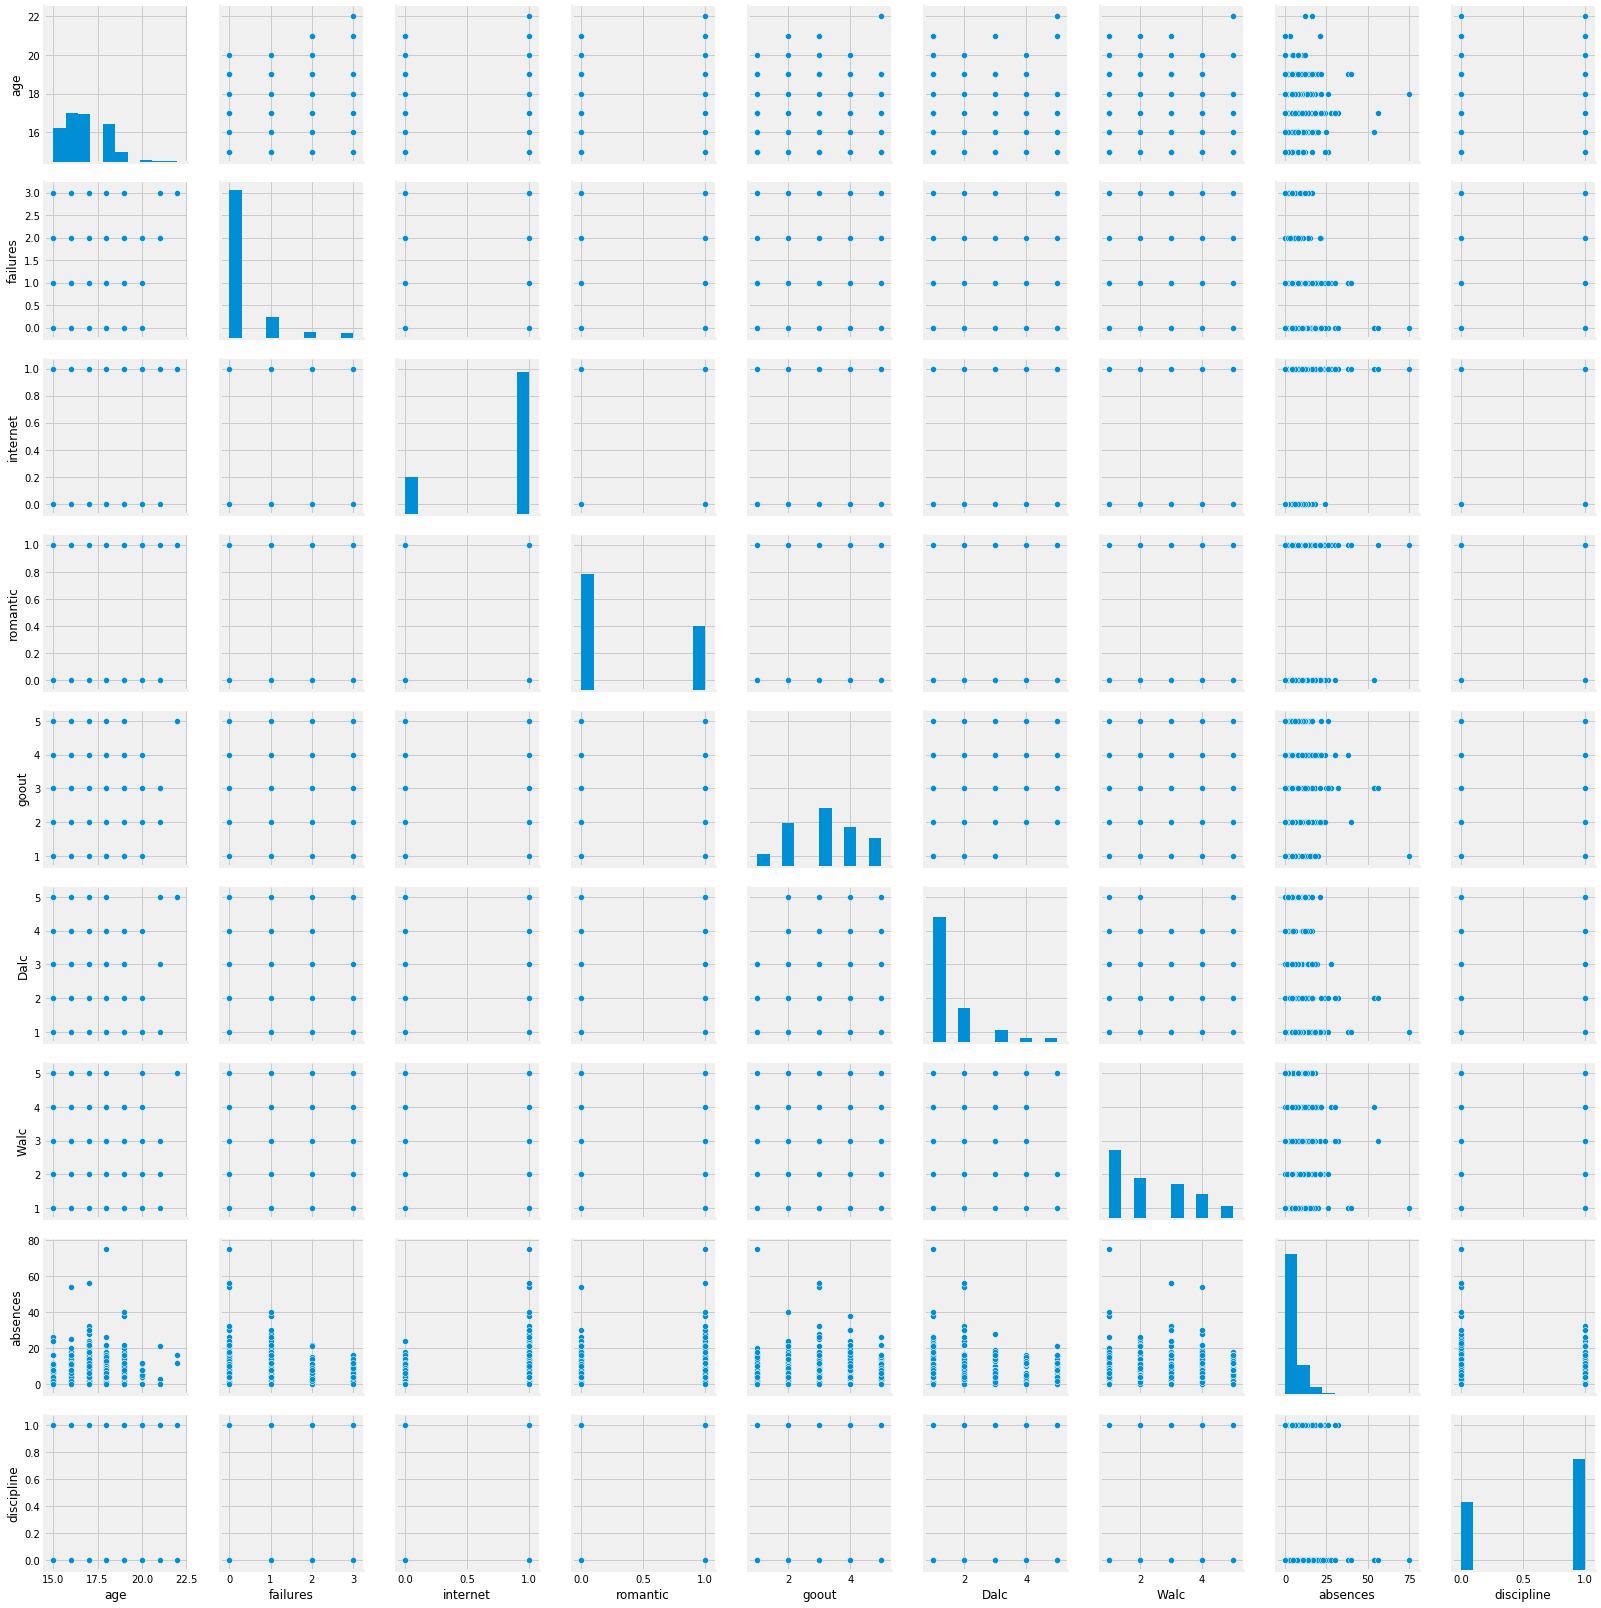

In [14]:
sns.pairplot(grades[['age', 'failures', 'internet', 'romantic', 'goout', 'Dalc', 'Walc', 'absences', 'discipline', 'final_grade_label']]);

# 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
#        'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup',
#        'famsup', 'paid', 'activities', 'higher', 'internet', 'romantic',
#        'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
#        'discipline', 'final_grade_label', 'final_grade_segment'

## Train - test split

In [15]:
feat_train, feat_test, grade_label_train, grade_label_test = train_test_split(feat, grade_label, test_size=0.3
                                                                                  , random_state=42, stratify=grade_label)

### Feature selection (with Random Forest)

In [31]:
#Naive way of getting feature importance
RF_model = RandomForestClassifier(n_estimators=10)
RF_model.fit(feat_train, grade_label_train)

grade_label_predict_RF = RF_model.predict(feat_train)
recall_RF = recall_score(grade_label_train, grade_label_predict_RF, pos_label='Pass')
precision_RF = precision_score(grade_label_train, grade_label_predict_RF, pos_label='Pass')
accuracy_RF = accuracy_score(grade_label_train, grade_label_predict_RF)
f1_RF = f1_score(grade_label_train, grade_label_predict_RF, pos_label='Pass')

print('Random Forest recall score is', str(round(recall_RF, 4)))
print('Random Forest precision score is', str(round(precision_RF, 4)))
print('Random Forest accuracy score is', str(round(accuracy_RF, 4)))
print('Random Forest F1 score is', str(round(f1_RF, 4)), '\n')

Random Forest recall score is 0.993
Random Forest precision score is 0.9878
Random Forest accuracy score is 0.9849
Random Forest F1 score is 0.9904 



In [32]:
feat_imp = []
for feat, imp in zip([f for f in feat_train.columns], RF_model.feature_importances_):
    feat_imp.append((feat, round(imp, 3)))

for feat, imp in sorted(feat_imp, key=lambda x: x[1], reverse=True):
    print(str(feat)+':', str(imp))

failures: 0.131
absences: 0.084
age: 0.069
goout: 0.052
health: 0.05
freetime: 0.049
Medu: 0.045
Walc: 0.041
discipline: 0.041
Fedu: 0.04
higher: 0.04
famrel: 0.04
studytime: 0.034
traveltime: 0.031
Dalc: 0.031
guardian: 0.03
famsup: 0.025
activities: 0.023
schoolsup: 0.022
internet: 0.022
romantic: 0.021
sex: 0.018
address: 0.017
paid: 0.017
famsize: 0.016
Pstatus: 0.012


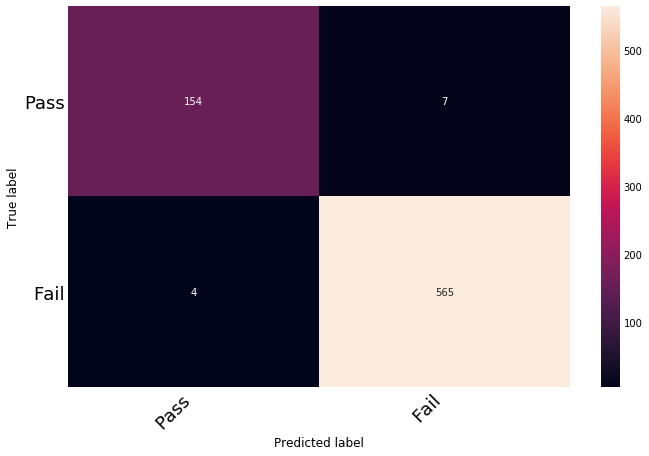

In [33]:
#Let's look at the confusion matrix
RF_conf_mat = confusion_matrix(grade_label_train, grade_label_predict_RF)
RF_conf_mat = print_confusion_matrix(RF_conf_mat, ['Pass', 'Fail'])

In [34]:
RF_cross_val = cross_val_score(RF_model, feat_train, grade_label_train, scoring='accuracy', cv = 10)

The mean of 10 fold cross validation accuracy score on Random Forest model is 0.784


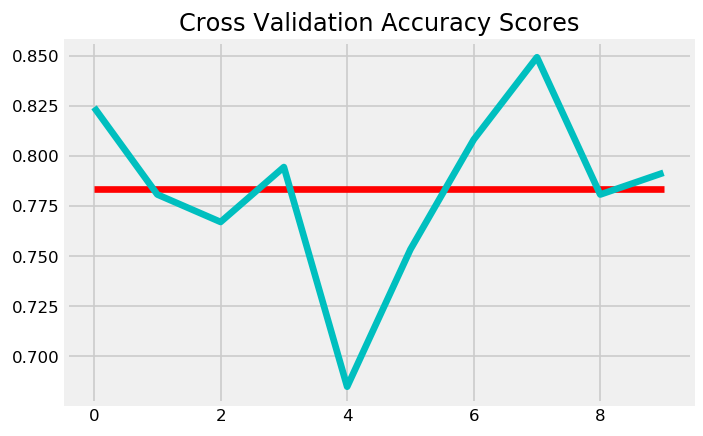

In [35]:
plt.figure(dpi=120)
plt.title('Cross Validation Accuracy Scores')
plt.plot([np.mean(RF_cross_val) for score in RF_cross_val], color='r')
plt.plot(RF_cross_val, color='c');

print('The mean of 10 fold cross validation accuracy score on Random Forest model is', str(round(np.mean(RF_cross_val), 3)))

### Can we do better with oversampling?

#### Random Over Sampler 

In [91]:
# Generate synthetic imbalanced data
feat_train_ROS, grade_label_train_ROS = make_classification(n_samples=5000,
                           n_clusters_per_class=1, 
                           class_sep=0.2, random_state=42)

In [92]:
Counter(grade_label_train_ROS)

Counter({0: 2498, 1: 2502})

In [94]:
RF_model_ROS = RandomForestClassifier(n_estimators=10)
RF_model_ROS.fit(feat_train_ROS, grade_label_train_ROS)
grade_label_predict_RF_ROS = RF_model_ROS.predict(feat_train_ROS)

(Random Over Sampler): The mean of 10 fold cross validation accuracy score on Random Forest model is 0.788


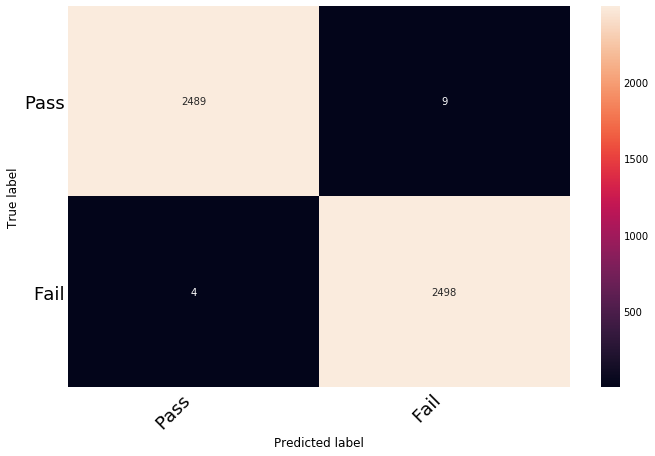

In [105]:
#Checking accuracy score on smoted model
RF_ROS_cross_val = cross_val_score(RF_model_ROS, feat_train, grade_label_train, scoring='accuracy', cv = 10)
print('(Random Over Sampler): The mean of 10 fold cross validation accuracy score on Random Forest model is', str(round(np.mean(RF_ROS_cross_val), 3)))

RF_ROS_cm = confusion_matrix(grade_label_train_ROS, grade_label_predict_RF_ROS)
RF_ROS_cm = print_confusion_matrix(RF_ROS_cm, ['Pass', 'Fail'])

> NIET GOED! >:(

#### SMOTE

In [36]:
feat_train_smoted, grade_label_train_smoted = SMOTE(random_state=42).fit_sample(feat_train, grade_label_train)
Counter(grade_label_train_smoted)

Counter({'Pass': 569, 'Fail': 569})

In [37]:
RF_model_smoted = RandomForestClassifier(n_estimators=10)
RF_model_smoted.fit(feat_train_smoted, grade_label_train_smoted)
grade_label_predict_RF_smoted = RF_model_smoted.predict(feat_train_smoted)

(SMOTE): The mean of 10 fold cross validation accuracy score on Random Forest model is 0.785


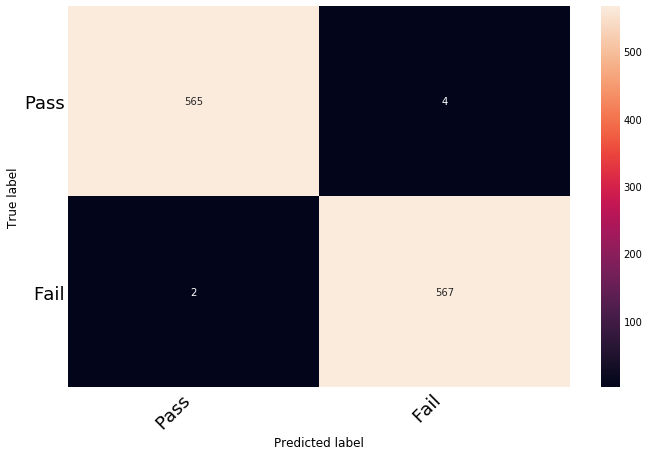

In [106]:
#Checking accuracy score on smoted model
RF_cross_val = cross_val_score(RF_model_smoted, feat_train, grade_label_train, scoring='accuracy', cv = 10)
print('(SMOTE): The mean of 10 fold cross validation accuracy score on Random Forest model is', str(round(np.mean(RF_cross_val), 3)))

RF_smoted_cm = confusion_matrix(grade_label_train_smoted, grade_label_predict_RF_smoted)
RF_smoted_cm = print_confusion_matrix(RF_smoted_cm, ['Pass', 'Fail'])

> Very decent!

#### ADASYN

In [102]:
feat_train_adasyn, grade_label_train_adasyn = ADASYN(random_state=42).fit_sample(feat_train, grade_label_train)
Counter(grade_label_train_adasyn)

Counter({'Pass': 569, 'Fail': 556})

In [103]:
RF_model_adasyn = RandomForestClassifier(n_estimators=10)
RF_model_adasyn.fit(feat_train_adasyn, grade_label_train_adasyn)
grade_label_predict_RF_adasyn = RF_model_adasyn.predict(feat_train_adasyn)

(ADASYN) The mean of 10 fold cross validation accuracy score on Random Forest model is 0.789


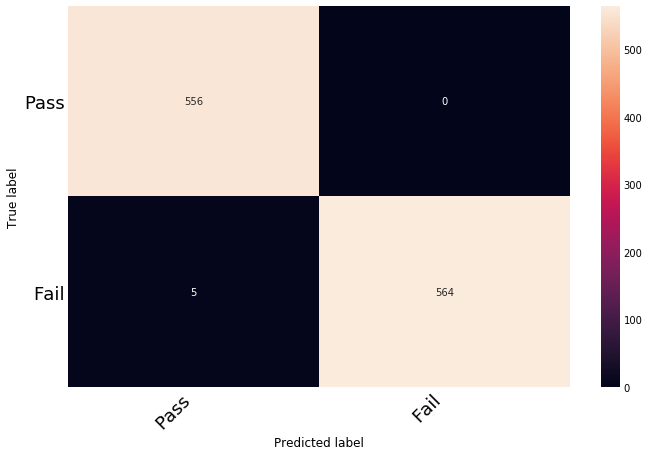

In [108]:
#Checking accuracy score on smoted model
RF_adasyn_cross_val = cross_val_score(RF_model_adasyn, feat_train, grade_label_train, scoring='accuracy', cv = 10)
print('(ADASYN) The mean of 10 fold cross validation accuracy score on Random Forest model is', str(round(np.mean(RF_adasyn_cross_val), 3)))

RF_adasyn_cm = confusion_matrix(grade_label_train_adasyn, grade_label_predict_RF_adasyn)
RF_adasyn_cm = print_confusion_matrix(RF_adasyn_cm, ['Pass', 'Fail'])

> Using ADASYN helps with False Negatives (down to 0), but makes False Positives worse (5 up from 2)

**And, indeed, we can, oversampling helps**

## Modelling Time

### KNN Classifier (in search for the optimal k)

In [42]:
k_range = range(1, 31)
weight_options = ['uniform', 'distance']
param_grid_knn = dict(n_neighbors=k_range, weights=weight_options)

grid_knn = GridSearchCV(knn, param_grid_knn, scoring='accuracy')
grid_knn.fit(feat_train, grade_label_train);

In [43]:
# examine the best model
print('Best score for knn cross validation is', str(round(grid_knn.best_score_, 3))+ '.')
print('Best parameters for knn cross validation are', str(grid_knn.best_params_)+ '.')
print('Best estimator for knn cross validation is the following:\n\t'+ str(grid_knn.best_estimator_))

Best score for knn cross validation is 0.789.
Best parameters for knn cross validation are {'n_neighbors': 10, 'weights': 'distance'}.
Best estimator for knn cross validation is the following:
	KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='distance')


### Can I create a pipeline and run cross_val on different models at ones?

In [111]:
model_list = [KNeighborsClassifier(n_neighbors=10, weights='distance'), LogisticRegression(C=0.1, random_state=42),
              RandomForestClassifier(n_estimators=10), SVC(1.0, kernel='linear'), GaussianNB(),
              SGDClassifier(loss='hinge', max_iter=1000, random_state=42)]

model_names = ['KNN', 'Logistic Regression', 'Random Forest', 'SVC', 'Naive Bayes', 'SDG']

In [112]:
model_scores = []

for i in range(len(model_list)):
    try_model = model_list[i]
    try_model.fit(feat_train, grade_label_train)
    the_avg_accuracy_score = cross_val_score(try_model, feat_train, grade_label_train, scoring='accuracy', cv=10)
    model_scores.append((model_names[i], round(np.mean(the_avg_accuracy_score), 3)))
    
print(model_scores)

[('KNN', 0.796), ('Logistic Regression', 0.794), ('Random Forest', 0.786), ('SVC', 0.797), ('Naive Bayes', 0.792), ('SDG', 0.767)]


> Forget Random Forest and SDG, then. SVC seems to be marginally better than KNN or Logistic Regression, but they're all worth exploring.
> Given that I already know the optimal parameters for KNN, the focus should now be on SVC and Logistic Regression